In [1]:
import pandas as pd
import pyspark
import json
from geopandas import GeoDataFrame
from shapely.geometry import Point
import numpy as np
from pyspark.sql import SparkSession
import pickle
from pyspark.sql.types import StructType,StructField, StringType, IntegerType,BooleanType,DoubleType
from pyspark.sql.functions import *
from matplotlib import pyplot as plt
%matplotlib inline

/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
ERROR 1: PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name
PROJ: proj_create_from_database: SQLite error on SELECT name, type, coordinate_system_auth_name, coordinate_system_code, datum_auth_name, datum_code, area_of_use_auth_name, area_of_use_code, text_definition, deprecated FROM geodetic_crs WHERE auth_name = ? AND code = ?: no such column: area_of_use_auth_name


In [2]:
pyspark.__version__

'2.4.0'

In [4]:
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("PySpark Read JSON") \
    .getOrCreate()

2022-08-30 15:51:55 WARN  Utils:66 - Your hostname, dell-7567 resolves to a loopback address: 127.0.1.1; using 192.168.0.101 instead (on interface wlp3s0)
2022-08-30 15:51:55 WARN  Utils:66 - Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


2022-08-30 15:51:55 WARN  NativeCodeLoader:62 - Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df = spark.read.json('data/traffic-2022-02.ndjson')

In [8]:
df.show()

+---------+---------+--------------------+----------+--------------------+------------+-----------------+--------------+--------------------+
|avg_speed|intensity|    segment_fullname|segment_id|    segment_location|segment_name|segment_road_name|speed_variance|           timestamp|
+---------+---------+--------------------+----------+--------------------+------------+-----------------+--------------+--------------------+
|    76.12|        9|D00-001: Praha-Sa...|  40000000|[50.1134674023, 1...|     D00-001|               D0|         55.82|2022-01-17T19:00:00Z|
|    79.09|       45|D00-001: Praha-Sa...|  40000000|[50.1134674023, 1...|     D00-001|               D0|         46.57|2022-01-17T19:00:00Z|
|     84.1|        8|D00-001: Praha-Ch...|  40000001|[50.1143633627, 1...|     D00-001|               D0|         18.19|2022-01-17T19:00:00Z|
|    82.36|       38|D00-001: Praha-Ch...|  40000001|[50.1143633627, 1...|     D00-001|               D0|         25.11|2022-01-17T19:00:00Z|
|    8

In [9]:
# row count
df.count()

IllegalArgumentException: 'Unsupported class file major version 55'

In [10]:
# unique segments
df.select('segment_id').distinct().count()

IllegalArgumentException: 'Unsupported class file major version 55'

In [ ]:
df.select('segment_fullname').distinct().count()

2234

In [ ]:
# segments with locations
segments = df.select('segment_id', 'segment_location').drop_duplicates().toPandas()
segments

,segment_id,segment_location
0,40002360,"(50.5225414072, 14.0059229341)"
1,40003080,"(50.4550984347, 15.2802124635)"
2,40003480,"(49.4215617841, 14.9735905167)"
3,40003961,"(49.4667409269, 13.6716167718)"
4,40006350,"(49.5108382427, 15.3401877346)"
...,...,...
2236,40015090,"(50.0777087372, 15.9007374493)"
2237,40015121,"(49.6618610171, 18.3384611526)"
2238,40015120,"(49.6605655023, 18.3439252741)"
2239,40015141,"(49.6776484537, 18.322120658)"


In [ ]:
segments['lat'] = segments['segment_location'].apply(lambda x: x[0])
segments['lon'] = segments['segment_location'].apply(lambda x: x[1])
segments['lat'] = segments.lat.astype(float)
segments['lon'] = segments.lon.astype(float)
geometry = [Point(xy) for xy in zip(segments.lon, segments.lat)]
segments_gdf = GeoDataFrame(segments, crs="EPSG:4326", geometry=geometry)

Text(0.5, 1.0, 'segment locations')

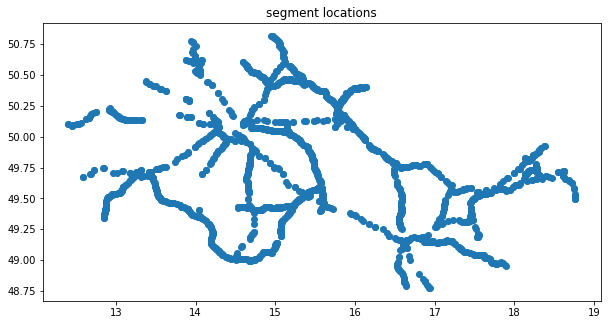

In [ ]:
# plot segments
ax = segments_gdf.plot(figsize=(10, 10))
ax.set_title('segment locations')

In [ ]:
# unique segment names
df.select('segment_name').distinct().count()

1128

In [ ]:
newDf = df.select('avg_speed', 'segment_id', 'segment_location', 
         'segment_road_name', 'speed_variance').toDF('avg_speed', 'segment_id', 'segment_location', 
         'segment_road_name', 'speed_variance')

In [ ]:
# avg speed stats

newDf.describe('avg_speed').show()

+-------+------------------+
|summary|         avg_speed|
+-------+------------------+
|  count|          10250001|
|   mean| 78.81880860889744|
| stddev|10.377966900687749|
|    min|                 0|
|    max|             99.99|
+-------+------------------+



In [ ]:
segment_avgSpd = newDf.groupby('segment_id').agg({'avg_speed': 'mean'}).toPandas()
avg_speed = segments_gdf.merge(segment_avgSpd, on='segment_id')

Text(0.5, 1.0, 'avg speed by segment')

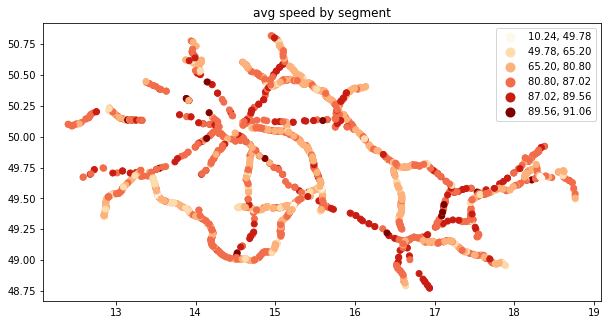

In [ ]:
ax = avg_speed.plot(column='avg(avg_speed)', cmap='OrRd', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
ax.set_title('avg speed by segment')

In [ ]:
# plot avg intensity by segments

segment_avgIntensity = df.groupby('segment_id').agg({'intensity': 'mean'}).toPandas()
avg_intensity = segments_gdf.merge(segment_avgIntensity, on='segment_id')

Text(0.5, 1.0, 'avg intensity by segment')

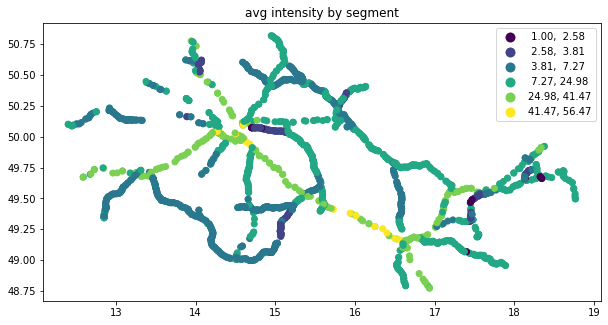

In [ ]:
ax = avg_intensity.plot(column='avg(intensity)', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
ax.set_title('avg intensity by segment')

In [ ]:
totalIntensity = df.select('intensity').toPandas()

In [ ]:
totalIntensity.intensity = totalIntensity.intensity.astype(int)
totalIntensity.describe()

,intensity
count,1.025000e+07
mean,1.144768e+01
std,1.752265e+01
min,1.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.300000e+01
max,2.750000e+02


Text(0.5, 1.0, 'intensity distribution over the observed month')

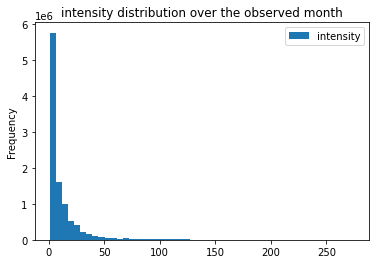

In [ ]:
totalIntensity.plot.hist(bins=50)
plt.title('intensity distribution over the observed month')

In [ ]:
df_hour = df.withColumn('hour', hour("timestamp").alias("hour"))
df_hour = df_hour.groupby('hour').agg({'intensity':'sum'}).toPandas()

([<matplotlib.axis.XTick at 0x19b3d29a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

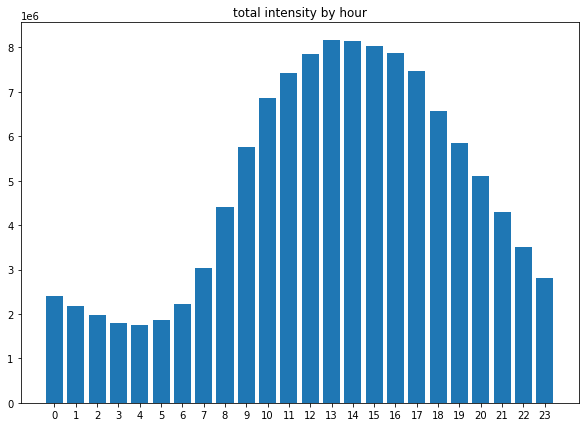

In [ ]:
plt.figure(figsize=(10, 7))
plt.bar(df_hour.hour, df_hour['sum(intensity)'])
plt.title('total intensity by hour')
plt.xticks(range(0, 24))

In [ ]:
df_week = df.withColumn('dayofweek', dayofweek("timestamp").alias("dayofweek"))
df_week = df_week.groupby('dayofweek').agg({'intensity':'sum'}).toPandas()

([<matplotlib.axis.XTick at 0x1910e9a90>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

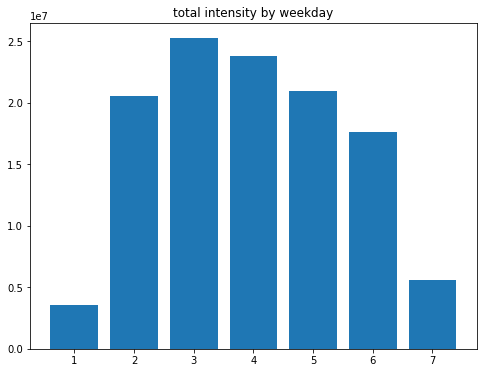

In [ ]:
plt.figure(figsize=(8, 6))
plt.bar(df_week.dayofweek, df_week['sum(intensity)'])
plt.title('total intensity by weekday')
plt.xticks(range(1, 8))

## understanding segment names/roads etc.

In [ ]:
# check segment names and attached segment ids

segment_names = df.groupby('segment_name').agg(collect_set('segment_id')).toPandas()
segment_names

,segment_name,collect_set(segment_id)
0,D00-001,"[40000000, 40000001]"
1,D00-002,"[40000010, 40000011]"
2,D00-003,"[40000021, 40000020]"
3,D00-004,"[40000031, 40000030]"
4,D00-005,"[40000040, 40000041]"
...,...,...
1123,I58-014,"[40015170, 40015171]"
1124,I63-001,"[40010701, 40010700]"
1125,I63-002,"[40010710, 40010711]"
1126,I63-003,"[40010721, 40010720]"


In [ ]:
segment_names

,segment_name,collect_set(segment_id)
0,D00-001,"[40000000, 40000001]"
1,D00-002,"[40000010, 40000011]"
2,D00-003,"[40000021, 40000020]"
3,D00-004,"[40000031, 40000030]"
4,D00-005,"[40000040, 40000041]"
...,...,...
1123,I58-014,"[40015170, 40015171]"
1124,I63-001,"[40010701, 40010700]"
1125,I63-002,"[40010710, 40010711]"
1126,I63-003,"[40010721, 40010720]"


In [ ]:
# check ids for a segment name D00-001
segments[segments.segment_id == '40000000']

,segment_id,segment_location,lat,lon,geometry
343,40000000,"(50.1134674023, 14.5878988032)",50.113467,14.587899,POINT (14.58790 50.11347)


In [ ]:
segments_gdf[segments_gdf.segment_id == '40000001']

,segment_id,segment_location,lat,lon,geometry
46,40000001,"(50.1143633627, 14.5882463921)",50.114363,14.588246,POINT (14.58825 50.11436)


Text(0.5, 1.0, 'segment locations')

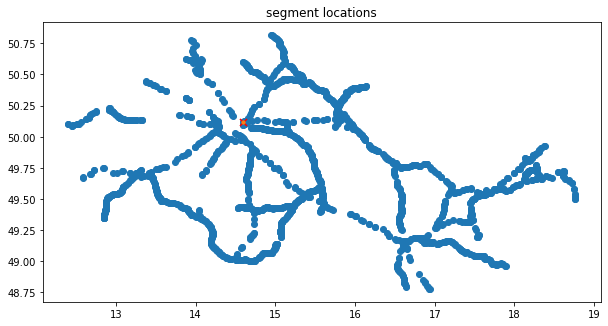

In [ ]:
# plot segments attached with a segment name 
ax = segments_gdf.plot(figsize=(10, 10))
segments_gdf[segments_gdf.segment_id == '40000000'].plot(color='red', marker='x', markersize=50, ax=ax)
segments_gdf[segments_gdf.segment_id == '40000001'].plot(marker='o', markersize=10, ax=ax)
ax.set_title('segment locations')

In [ ]:
# most segment names seem to have 2 segment ids associated with it, which seems to be overlapping, 

In [ ]:
# segment name with locations
segment_name = df.select('segment_name', 'segment_road_name', 'segment_location').drop_duplicates(subset=['segment_name']).toPandas()

segment_name['lat'] = segment_name['segment_location'].apply(lambda x: x[0])
segment_name['lon'] = segment_name['segment_location'].apply(lambda x: x[1])
segment_name['lat'] = segment_name.lat.astype(float)
segment_name['lon'] = segment_name.lon.astype(float)
geometry = [Point(xy) for xy in zip(segment_name.lon, segment_name.lat)]
segment_name_gdf = GeoDataFrame(segment_name, crs="EPSG:4326", geometry=geometry)

Text(0.5, 1.0, 'segment name locations')

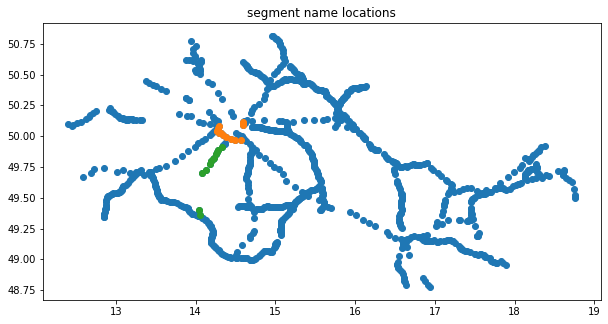

In [ ]:
# plot segments
ax = segment_name_gdf.plot(figsize=(10, 10))
segment_name_gdf[segment_name_gdf.segment_road_name == 'D0'].plot(figsize=(10, 10), ax=ax)
segment_name_gdf[segment_name_gdf.segment_road_name == 'D4'].plot(figsize=(10, 10), ax=ax)
ax.set_title('segment name locations')

In [ ]:
segment_name_gdf.segment_road_name.unique()

array(['D0', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D10', 'D11',
       'D35', 'D46', 'D48', 'D52', 'D55', 'D56', '3', '4', '6', '7', '11',
       '12', '16', '19', '20', '26', '30', '33', '34', '35', '37', '38',
       '43', '46', '47', '48', '50', '52', '55', '58', '63'], dtype=object)

In [ ]:
segment_name_gdf.to_csv('czech_roads.csv', index=False)

## make and visualize the network

In [ ]:
connections = pd.DataFrame({'segment_from':['D00-015', 'D05-017','I26-005', 
                                   'D05-014', 'D06-008', 'D07-006', 'I07-001', 'D07-001', 'D00-015', 'D06-001', 
                                   'D05-001', 'D05-001', 'I04-001', 'I04-001', 'D00-004', 'D00-004', 
                                   'I03-001', 'I03-001', 'D04-011', 'D04-011', 'I20-088', 'D03-013', 
                                   'D03-013', 'I19-011', 'I19-011', 'D03-001', 'D11-001', 'D11-001', 'D10-001', 
                                   'I12-001', 'I38-025', 'I38-025', 'I12-029', 'I12-029', 'I34-092', 
                                   'I34-092', 'D01-020', 'D01-020', 'D01-018', 'D01-018', 'D35-001', 
                                   'D35-001', 'I11-001', 'I11-001', 'D11-013', 'D11-013', 'I11-004', 'I35-071', 
                                   'I35-071', 'D35-016', 'D35-016', 'D02-001', 'D02-001', 'I52-001', 
                                   'I52-001', 'I50-001', 'I50-001', 'I43-038', 'I43-038', 'D46-001', 
                                   'D46-001', 'I35-126', 'D46-011', 'D46-011', 'I46-001', 'D35-008', 
                                   'D35-008', 'I35-124', 'D01-051', 'D01-051', 'D35-013', 'D48-001', 
                                   'D48-001', 'I58-013', 'I58-013', 'D56-007', 'D56-007', 'I11-005', 
                                   'I11-020', 'I11-020'], 'segment_to':
                            ['D06-001', 'I26-005', 'D05-016', 'I20-005', 'I06-025', 'I07-002', 'D07-005', 
                            'D00-015', 'D06-001', 'D00-014', 'D00-012', 'D00-013', 'D00-007', 'D00-006', 
                            'D01-005', 'D01-004', 'D01-008', 'D01-007', 'I20-052', 'I20-053', 'I34-001', 
                            'I34-001', 'I34-002', 'D03-003', 'D03-002', 'I03-027', 'D00-003', 'D00-002', 
                            'D00-001', 'D00-003', 'D11-006', 'D11-005', 'I38-033', 'I38-034', 'I38-079', 
                            'I38-080', 'I38-093', 'I38-092', 'I34-077', 'I34-078', 'D11-012', 'D11-011', 
                            'D11-012', 'D11-013', 'I35-071', 'I35-070', 'I33-001', 'I33-001', 'I11-004', 
                            'I35-079', 'I35-080', 'D01-032', 'D01-033', 'D01-032', 'D01-031', 'D01-037', 
                            'D01-038', 'I35-106', 'I35-105', 'D01-040', 'D01-041', 'D35-007', 'D35-007', 
                            'I46-001', 'D35-007', 'I46-001', 'D46-011', 'D35-002', 'D35-013', 'D01-050', 
                            'D01-050', 'D01-052', 'D01-053', 'D48-008', 'D48-007', 'D48-003', 'D48-011', 
                            'D48-006', 'D01-058', 'D01-059']})
connections

,segment_from,segment_to
0,D00-015,D06-001
1,D05-017,I26-005
2,I26-005,D05-016
3,D05-014,I20-005
4,D06-008,I06-025
...,...,...
75,D56-007,D48-003
76,D56-007,D48-011
77,I11-005,D48-006
78,I11-020,D01-058


In [ ]:
within_roads = []

for road in segment_name_gdf.segment_road_name.unique():
    
    road_temp = segment_name_gdf[segment_name_gdf.segment_road_name == road]
    road_temp['segment_from'] = road_temp[['segment_name']].shift()
    road_temp.rename(columns={'segment_name':'segment_to'}, inplace=True)
    within_roads.append(road_temp[['segment_from', 'segment_to']])

/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
/Users/devashishkhulbe/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
within_roads.append(connections)
segment_connections = pd.concat(within_roads)
segment_connections.dropna(inplace=True)
segment_connections.reset_index(drop=True, inplace=True)
segment_connections

,segment_from,segment_to
0,D00-001,D00-002
1,D00-002,D00-003
2,D00-003,D00-004
3,D00-004,D00-005
4,D00-005,D00-006
...,...,...
1161,D56-007,D48-003
1162,D56-007,D48-011
1163,I11-005,D48-006
1164,I11-020,D01-058


In [ ]:
import networkx as nx

#creare a directed graph subway network
segments_graph=nx.Graph()
for i in segment_connections.index:
    segments_graph.add_edge(segment_connections.segment_from[i],segment_connections.segment_to[i])   
    
#create a dictionary of subway stations by name and location
StPos={segment_name_gdf.segment_name[c]:(segment_name_gdf.lon[c],
                                         segment_name_gdf.lat[c]) for c in segment_name_gdf.index}
# StName={segment_name_gdf.id[c]:segment_name_gdf.name[c] for c in Stations.index}

In [ ]:
#segments_graph.remove_edge('D06-017', 'D06-018')
# segments_graph.remove_edge('D06-007', 'D06-008')
# segments_graph.remove_edge('D06-006', 'D06-007')
# segments_graph.remove_edge('D05-025', 'D05-024')
# segments_graph.remove_edge('I07-002', 'I07-003')
# segments_graph.remove_edge('D07-005', 'D07-006')
#segments_graph.remove_edge('I11-005', 'I11-004')
#segments_graph.remove_edge('I35-126', 'I35-127')
#segments_graph.remove_edge('I35-129', 'I35-128')
#segments_graph.remove_edge('I11-016', 'I11-015')
#segments_graph.remove_edge('D35-015', 'D35-014')
#segments_graph.remove_edge('I35-140', 'I35-141')
#segments_graph.remove_edge('D04-012', 'D04-011')

In [ ]:
# segments_graph.add_edge('D06-007', 'D06-021')
# segments_graph.add_edge('D06-007', 'I06-001')
#segments_graph.add_edge('D06-006', 'D06-018')
#segments_graph.add_edge('I07-003', 'D07-010')

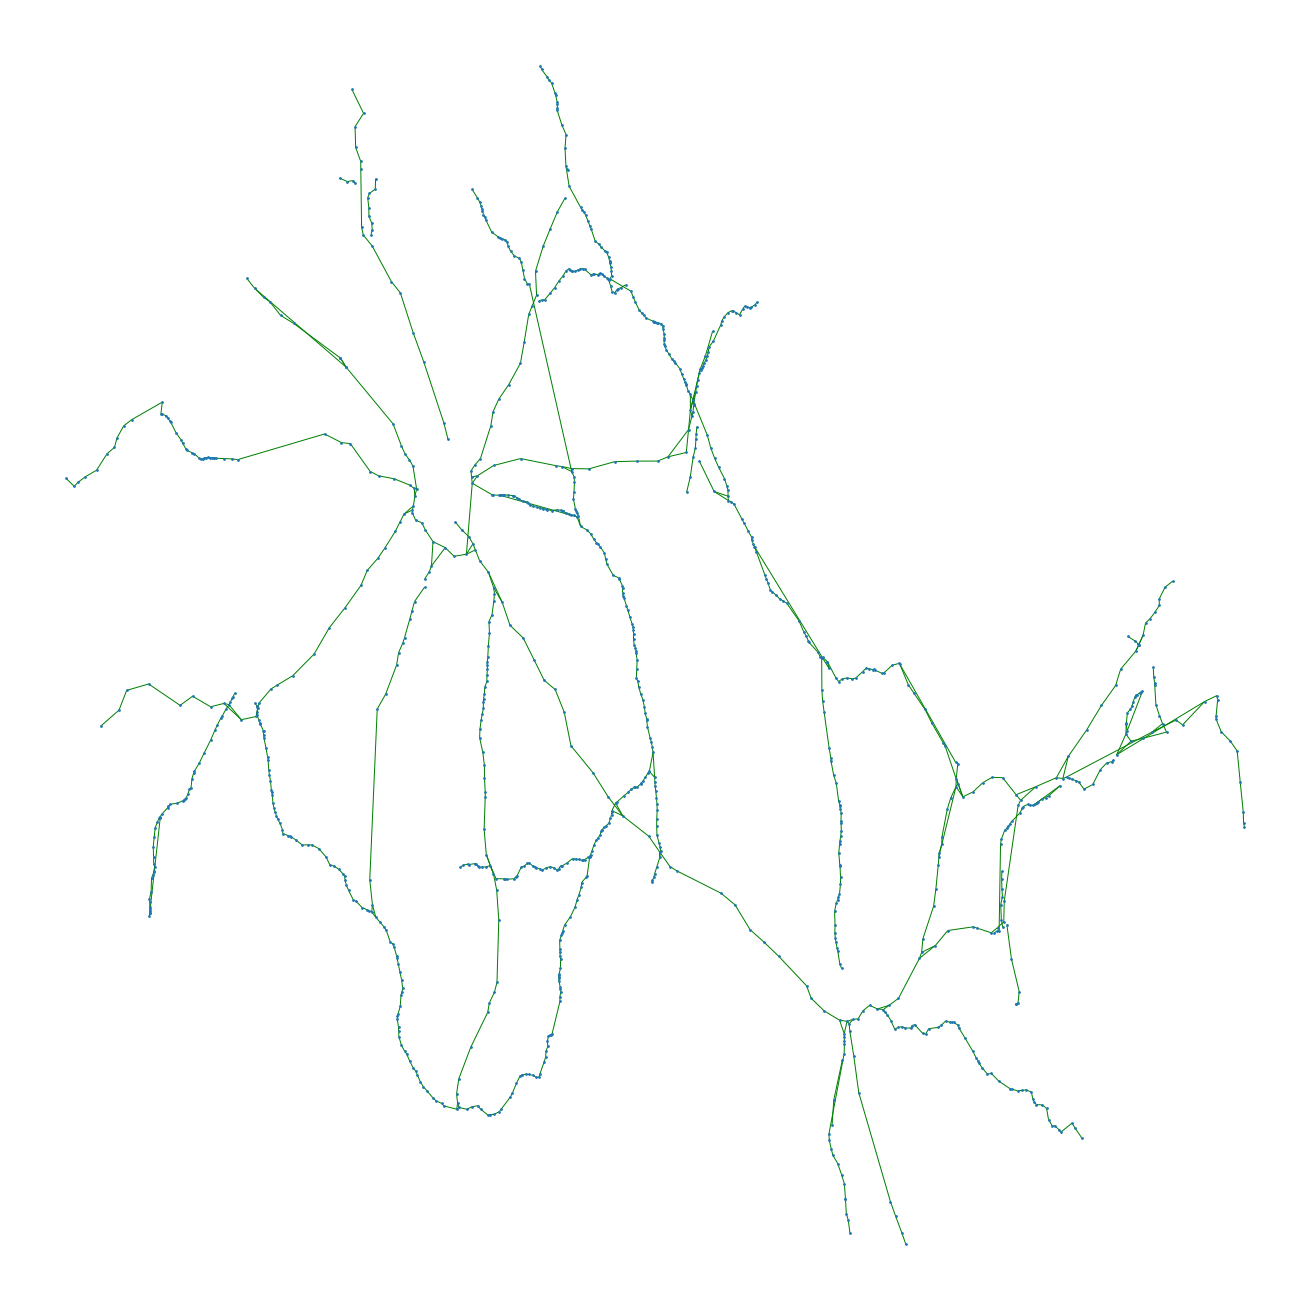

In [ ]:
#visualize the road newtork
plt.figure(figsize = (18,18))
nx.draw(segments_graph,pos=StPos,with_labels=False,arrows=False,node_size=3,width=1,edge_color='green')

In [ ]:
segments_graph_df = nx.to_pandas_edgelist(segments_graph)
segments_graph_df = segments_graph_df.rename(columns={'source':'segment_from', 'target':'segment_to'})
segments_graph_df.to_csv('czech_road_connections.csv', index=False)

In [ ]:
with open("czech_road_network.p", 'wb') as f:
    pickle.dump(segments_graph, f)
    
with open("czech_road_network.p", 'rb') as f:  # notice the r instead of w
    G_loaded = pickle.load(f)

In [ ]:
# segment_full_name

segment_fullnames = df.groupby('segment_fullname').agg(collect_set('segment_id')).toPandas()
segment_fullnames.head()

,segment_fullname,collect_set(segment_id)
0,D00-001: Praha-Chlumecká - Praha-Satalice,[40000001]
1,D00-001: Praha-Satalice - Praha-Chlumecká,[40000000]
2,D00-002: Praha-Chlumecká - Praha-Horní Počernice,[40000010]
3,D00-002: Praha-Horní Počernice - Praha-Chlumecká,[40000011]
4,D00-003: Praha-Běchovice - Praha-Horní Počernice,[40000021]


In [ ]:
# segments full names which have mutiple ids

segment_fullnames['id_length'] = segment_fullnames['collect_set(segment_id)'].apply(lambda x:
                                                                                    len(x))
segment_fullnames[segment_fullnames.id_length > 1]

,segment_fullname,collect_set(segment_id),id_length
434,D35-001: Opatovice nad Labem - Sedlice,"[40001281, 40015321]",2
435,D35-001: Sedlice - Opatovice nad Labem,"[40015320, 40001280]",2
520,D55-003: Otrokovice-sever - Otrokovice-východ,"[40015380, 40001970]",2
521,D55-003: Otrokovice-východ - Otrokovice-sever,"[40001971, 40015381]",2
536,D56-006: Frýdek-Místek - Staříč,"[40002021, 40015151]",2
537,D56-006: Staříč - Frýdek-Místek,"[40002020, 40015150]",2
2012,I47-013: Lipník nad Bečvou 1 - Lipník nad Bečv...,"[40015340, 40012160]",2


In [ ]:
# check for a particular segment full name

segments_gdf[segments_gdf.segment_id == '40001281']

,segment_id,segment_location,lat,lon,geometry
1584,40001281,"(50.1426838458, 15.759507023)",50.142684,15.759507,POINT (15.75951 50.14268)


In [ ]:
segments_gdf[segments_gdf.segment_id == '40015321']

,segment_id,segment_location,lat,lon,geometry
2234,40015321,"(50.1426838458, 15.759507023)",50.142684,15.759507,POINT (15.75951 50.14268)


In [ ]:
# repeated location

In [ ]:
# check another

segments_gdf[segments_gdf.segment_id == '40015320']

,segment_id,segment_location,lat,lon,geometry
2180,40015320,"(50.1453806671, 15.7503913329)",50.145381,15.750391,POINT (15.75039 50.14538)


In [ ]:
segments_gdf[segments_gdf.segment_id == '40001280']

,segment_id,segment_location,lat,lon,geometry
1435,40001280,"(50.1453806671, 15.7503913329)",50.145381,15.750391,POINT (15.75039 50.14538)


In [ ]:
# another repeated


In [ ]:
# roads

df.select('segment_road_name').distinct().count()

42

In [ ]:
# roads with segment ids

roads = df.groupby('segment_road_name').agg(collect_set('segment_id')).toPandas()
roads

,segment_road_name,collect_set(segment_id)
0,7,"[40010741, 40010750, 40010751, 40010761, 40010..."
1,D5,"[40001771, 40001870, 40012270, 40001791, 40001..."
2,D7,"[40002440, 40002251, 40002240, 40002441, 40015..."
3,11,"[40010781, 40002461, 40002530, 40002550, 40002..."
4,3,"[40004991, 40005251, 40005051, 40005001, 40005..."
5,30,"[40005330, 40005331, 40005340, 40005261, 40005..."
6,34,"[40005630, 40005781, 40005950, 40006191, 40006..."
7,16,"[40002900, 40003081, 40002951, 40003101, 40003..."
8,35,"[40010920, 40006970, 40006571, 40006811, 40006..."
9,52,"[40010120, 40010110, 40010231, 40010161, 40010..."


In [ ]:
# roads with segment names

roads = df.groupby('segment_road_name').agg(collect_set('segment_name')).toPandas()
roads

,segment_road_name,collect_set(segment_name)
0,7,"[I07-003, I07-001, I07-002]"
1,D5,"[D05-022, D05-007, D05-024, D05-008, D05-009, ..."
2,D7,"[D07-002, D07-007, D07-001, D07-003, D07-008, ..."
3,11,"[I11-012, I11-020, I11-003, I11-017, I11-014, ..."
4,3,"[I03-024, I03-023, I03-025, I03-014, I03-001, ..."
5,30,"[I30-003, I30-009, I30-002, I30-004, I30-006, ..."
6,34,"[I34-039, I34-085, I34-068, I34-084, I34-048, ..."
7,16,"[I16-003, I16-018, I16-025, I16-023, I16-009, ..."
8,35,"[I35-075, I35-008, I35-018, I35-068, I35-048, ..."
9,52,"[I52-010, I52-001, I52-002, I52-003, I52-005, ..."


In [ ]:
# roads with locations
roads = df.select('segment_road_name', 'segment_location').drop_duplicates().toPandas()
roads

,segment_road_name,segment_location
0,D3,"(49.2087372714, 14.7131620552)"
1,16,"(50.4252548535, 15.3486218834)"
2,19,"(49.4063686168, 14.7228327035)"
3,26,"(49.606722041, 13.1199451473)"
4,35,"(50.7397532292, 15.0520580344)"
...,...,...
2225,D11,"(50.3528857466, 15.8885917498)"
2226,D48,"(49.6605655023, 18.3439252741)"
2227,D48,"(49.6618610171, 18.3384611526)"
2228,D56,"(49.6753122615, 18.3223923243)"


Text(0.5, 1.0, 'avg intensity by road')

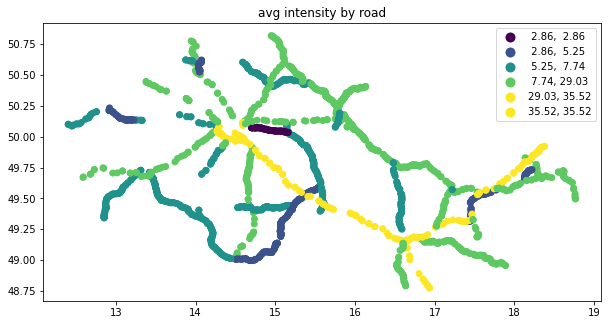

In [ ]:
# avg intensity by road

roads_avgInt = df.groupby('segment_road_name').agg({'intensity': 'mean'}).toPandas()
roads['lat'] = roads['segment_location'].apply(lambda x: x[0])
roads['lon'] = roads['segment_location'].apply(lambda x: x[1])
roads['lat'] = roads.lat.astype(float)
roads['lon'] = roads.lon.astype(float)
geometry = [Point(xy) for xy in zip(roads.lon, roads.lat)]
roads_gdf = GeoDataFrame(roads, crs="EPSG:4326", geometry=geometry)
roads_avgIntensity = roads_gdf.merge(roads_avgInt, on='segment_road_name')
roads_avgIntensity.plot(column='avg(intensity)', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
plt.title('avg intensity by road')

Text(0.5, 1.0, 'avg speed by road')

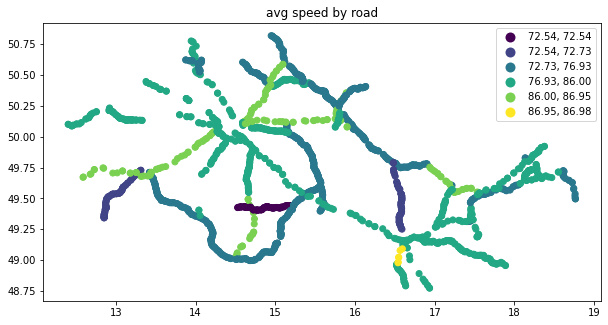

In [ ]:
# avg speed by road

roads_avgSp = df.groupby('segment_road_name').agg({'avg_speed': 'mean'}).toPandas()
roads_avgSpeed = roads_gdf.merge(roads_avgSp, on='segment_road_name')
roads_avgSpeed.plot(column='avg(avg_speed)', k=10, scheme='Percentiles', figsize=(10, 10), 
                    legend=True)
plt.title('avg speed by road')

In [ ]:
df

DataFrame[avg_speed: string, intensity: string, segment_fullname: string, segment_id: string, segment_location: struct<lat:string,lon:string>, segment_name: string, segment_road_name: string, speed_variance: string, timestamp: string]

In [ ]:
## 15 min data aggregation

seconds = 900
epoch = (col("timestamp").cast("timestamp").cast("bigint") / seconds).cast(
    "bigint"
) * seconds

In [ ]:
df_1 = df.withColumn("epoch", epoch)

In [ ]:
df_1 = df_1.withColumn("intensity", df_1["intensity"].cast(IntegerType()))

In [ ]:
min_epoch, max_epoch = df_1.select(min("epoch"), max("epoch")).first()

ref = spark.range(min_epoch, max_epoch + seconds, seconds).toDF("epoch")

In [ ]:
(
    ref.join(df_1, "epoch", "left")
    .withColumn("ts_resampled", timestamp_seconds("epoch"))
    .groupBy("segment_name", "ts_resampled")
    .sum("intensity")
    .orderBy("ts_resampled")
    .fillna(0, subset=["sum(intensity)"])
    .show(truncate=False)
)

22/08/17 19:25:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/17 19:25:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
+------------+-------------------+--------------+
|segment_name|ts_resampled       |sum(intensity)|
+------------+-------------------+--------------+
|D00-001     |2022-01-18 00:30:00|100           |
|D00-002     |2022-01-18 00:30:00|108           |
|D00-003     |2022-01-18 00:30:00|123           |
|D00-004     |2022-01-18 00:30:00|134           |
|D00-005     |2022-01-18 00:30:00|138           |
|D00-006     |2022-01-18 00:30:00|122           |
|D00-007     |2022-01-18 00:30:00|132           |
|D00-008     |2022-01-18 00:30:00|130           |
|D00-009     |2022-01-18 00:30:00|121           |
|D00-010     |2022-01-18 00:30:00|111           |
|D00-011     |2022-01-18 00:30:00|120           |
|D00-012     |2022-01-18 00:30:00|111           |
|D00-013     |20

In [ ]:
df_1

DataFrame[avg_speed: string, intensity: int, segment_fullname: string, segment_id: string, segment_location: struct<lat:string,lon:string>, segment_name: string, segment_road_name: string, speed_variance: string, timestamp: string, epoch: bigint]

In [ ]:
df_ = (
    ref.join(df_1, "epoch", "left")
    .withColumn("ts_resampled", timestamp_seconds("epoch"))
    .groupBy("segment_name", "ts_resampled")
    .sum("intensity")
    .orderBy("ts_resampled")
    .fillna(0, subset=["sum(intensity)"])
)

In [ ]:
df_.show()

22/08/17 19:37:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/17 19:37:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
+------------+-------------------+--------------+
|segment_name|       ts_resampled|sum(intensity)|
+------------+-------------------+--------------+
|     D00-001|2022-01-18 00:30:00|           100|
|     D00-002|2022-01-18 00:30:00|           108|
|     D00-003|2022-01-18 00:30:00|           123|
|     D00-004|2022-01-18 00:30:00|           134|
|     D00-005|2022-01-18 00:30:00|           138|
|     D00-006|2022-01-18 00:30:00|           122|
|     D00-007|2022-01-18 00:30:00|           132|
|     D00-008|2022-01-18 00:30:00|           130|
|     D00-009|2022-01-18 00:30:00|           121|
|     D00-010|2022-01-18 00:30:00|           111|
|     D00-011|2022-01-18 00:30:00|           120|
|     D00-012|2022-01-18 00:30:00|           111|
|     D00-013|20

In [ ]:
df_

DataFrame[segment_name: string, ts_resampled: timestamp, sum(intensity): bigint]

In [ ]:
df__ = df_.groupBy("ts_resampled").pivot('segment_name').agg(sum('sum(intensity)'))

In [ ]:
df1 = df__.select('ts_resampled', 'D00-001').toPandas()

22/08/18 09:50:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/18 09:50:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/18 09:50:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/08/18 09:50:22 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


In [ ]:
df1

,ts_resampled,D00-001
0,2022-01-18 00:30:00,100
1,2022-01-18 00:45:00,118
2,2022-01-18 01:00:00,81
3,2022-01-18 01:15:00,68
4,2022-01-18 01:30:00,80
...,...,...
3039,2022-02-14 05:15:00,68
3040,2022-02-14 05:30:00,80
3041,2022-02-14 05:45:00,83
3042,2022-02-14 06:00:00,86
